In [7]:
import pandas as pd
import numpy as np

# ----------------------------------------
# 1. Archivos de entrada
# ----------------------------------------
season_files = {
    "Invierno": "listos/invierno.csv",
    "Primavera": "listos/primavera.csv",
    "Verano":   "listos/verano.csv",
    "Otoño":    "listos/otoño.csv",
}

# ----------------------------------------
# 2. Función para calcular índices ecológicos
# ----------------------------------------
def ecological_indices(group: pd.DataFrame) -> pd.Series:
    """
    Calcula N, S, H (Shannon) y E (Pielou) para un grupo dado.
    group debe tener una columna 'Abundancia'.
    """
    abund = group["Abundancia"].values.astype(float)

    N = abund.sum()
    S = (abund > 0).sum()

    if N == 0 or S == 0:
        return pd.Series({"N": 0.0, "S": 0, "H": 0.0, "E": 0.0})

    p = abund / N
    p = p[p > 0]  # evitar log(0)

    H = -np.sum(p * np.log(p))
    E = H / np.log(S) if S > 1 else 0.0

    return pd.Series({"N": N, "S": S, "H": H, "E": E})


# ----------------------------------------
# 3. Construcción del dataset largo
# ----------------------------------------
all_data = []

for estacion, fname in season_files.items():
    print(f"Procesando {fname} para estación {estacion}...")

    df = pd.read_csv(fname)

    if "Especie" not in df.columns:
        raise ValueError(f"El archivo {fname} no tiene la columna 'Especie'.")

    # Columnas que NO son sitios (las excluimos del melt)
    base_exclude = ["Especie", "Rotiferos", "Copepodos", "Cladoceros"]
    exclude_cols = [c for c in base_exclude if c in df.columns]
    site_cols = [col for col in df.columns if col not in exclude_cols]

    df_long = df.melt(
        id_vars=exclude_cols,
        value_vars=site_cols,
        var_name="Sitio",
        value_name="Abundancia"
    )

    df_long["Abundancia"] = df_long["Abundancia"].fillna(0)
    df_long["Estacion"] = estacion

    all_data.append(df_long)

data_long = pd.concat(all_data, ignore_index=True)

# ----------------------------------------
# 4. Separar Laguna y Sector
# ----------------------------------------
lag_sec = data_long["Sitio"].str.rsplit(" ", n=1, expand=True)
lag_sec.columns = ["Laguna", "Sector"]
data_long = pd.concat([data_long, lag_sec], axis=1)

# ----------------------------------------
# 5. Cálculo de índices por Laguna–Sector–Estación
# ----------------------------------------
indices = (
    data_long.groupby(["Laguna", "Sector", "Estacion"], as_index=False)
    .apply(ecological_indices)
)

# compatibilidad con posibles MultiIndex en columnas
if isinstance(indices.columns, pd.MultiIndex):
    indices.columns = indices.columns.get_level_values(-1)

# ----------------------------------------
# 6. Guardar resultado
# ----------------------------------------
indices.to_csv("indices_ecologicos_por_sector.csv", index=False)
print("\n✅ Archivo generado: indices_ecologicos_por_sector.csv")



Procesando listos/invierno.csv para estación Invierno...
Procesando listos/primavera.csv para estación Primavera...
Procesando listos/verano.csv para estación Verano...
Procesando listos/otoño.csv para estación Otoño...

✅ Archivo generado: indices_ecologicos_por_sector.csv


C:\Users\Facu\AppData\Local\Temp\ipykernel_3680\3612072897.py:83: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(ecological_indices)


### Media y desvio resumen

In [9]:
# Si el dataframe ya existe, no cargues. Si no:
df = pd.read_csv("indices_ecologicos_por_sector.csv")

# Ordenar estación para mantener lógica temporal
orden_estaciones = ["Invierno", "Primavera", "Verano", "Otoño"]
df["Estacion"] = pd.Categorical(df["Estacion"], categories=orden_estaciones, ordered=True)

# ---- Agrupar por laguna y por estación ----
resumen = (
    df.groupby(["Laguna", "Estacion"])
      .agg(
        N_mean=("N", "mean"),
        N_sd=("N", "std"),
        S_mean=("S", "mean"),
        S_sd=("S", "std"),
        H_mean=("H", "mean"),
        H_sd=("H", "std"),
        E_mean=("E", "mean"),
        E_sd=("E", "std"),
      )
      .reset_index()
)

# Mostrar preview
print(resumen)

# Guardar archivo final
resumen.to_csv("resumen_ecologico_laguna_estacion.csv", index=False, float_format="%.4f")
print("\n📁 Archivo generado: resumen_ecologico_laguna_estacion.csv")


       Laguna   Estacion        N_mean          N_sd     S_mean      S_sd  \
0      Crespo   Invierno      3.136600      2.687802   5.000000  0.000000   
1      Crespo  Primavera    217.222222    141.522803  10.333333  4.509250   
2      Crespo     Verano    213.703704    130.513390  10.000000  2.645751   
3      Crespo      Otoño    142.407407     39.048614   9.333333  1.154701   
4   Espinillo   Invierno      3.480895      2.153919  10.666667  2.886751   
5   Espinillo  Primavera    205.555556    147.923904  14.000000  3.605551   
6   Espinillo     Verano     63.555556      3.906310  11.666667  6.027714   
7   Espinillo      Otoño     42.478632     61.597772   5.666667  0.577350   
8      Gazano   Invierno  12254.770531  11373.277049   5.000000  1.000000   
9      Gazano  Primavera   2130.370370   2881.918157  11.333333  1.527525   
10     Gazano     Verano   1536.666667   1340.310909   8.666667  1.154701   
11     Gazano      Otoño   3003.333333   3128.849629   5.666667  1.154701   

C:\Users\Facu\AppData\Local\Temp\ipykernel_3680\2916214757.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["Laguna", "Estacion"])


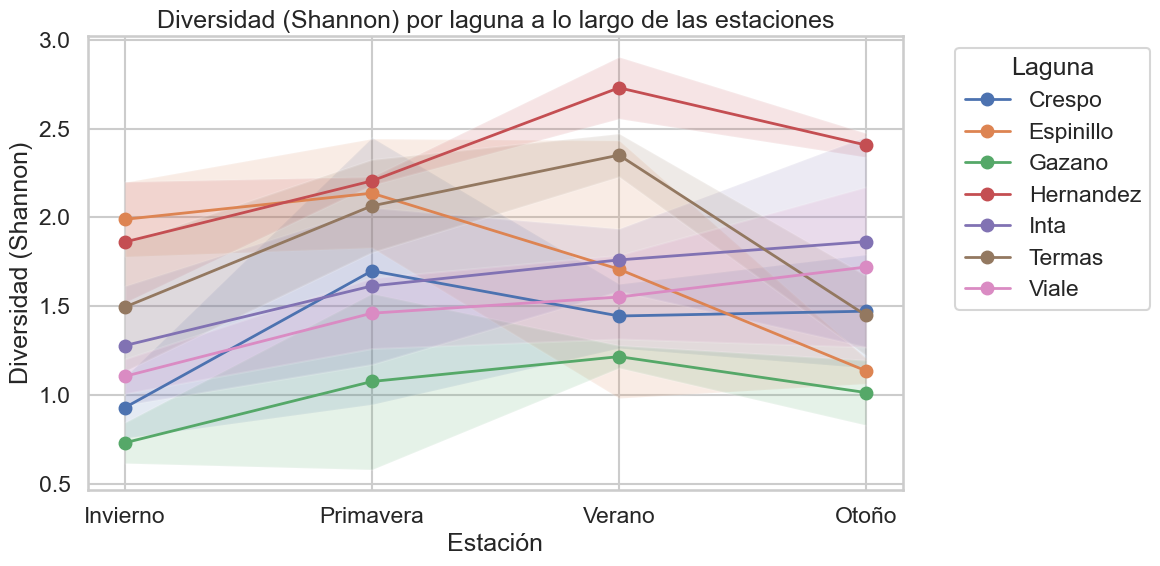

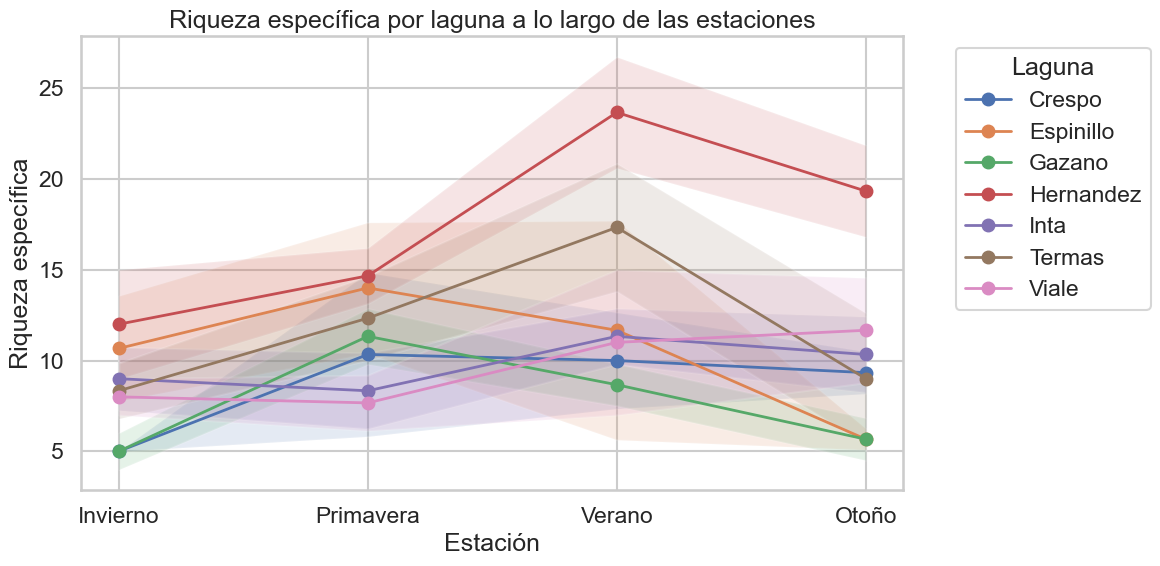

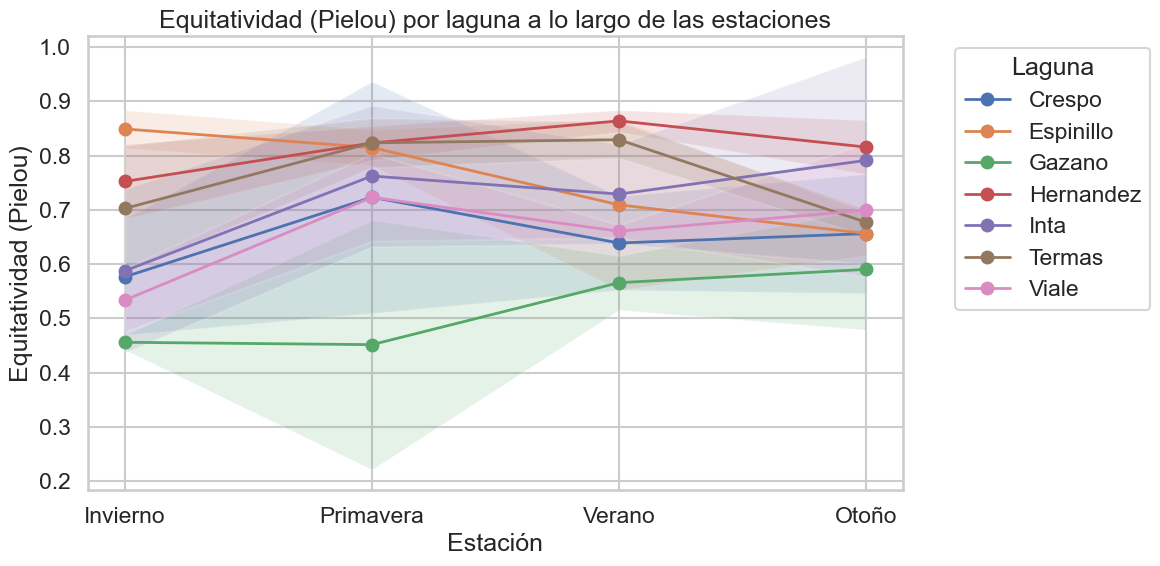

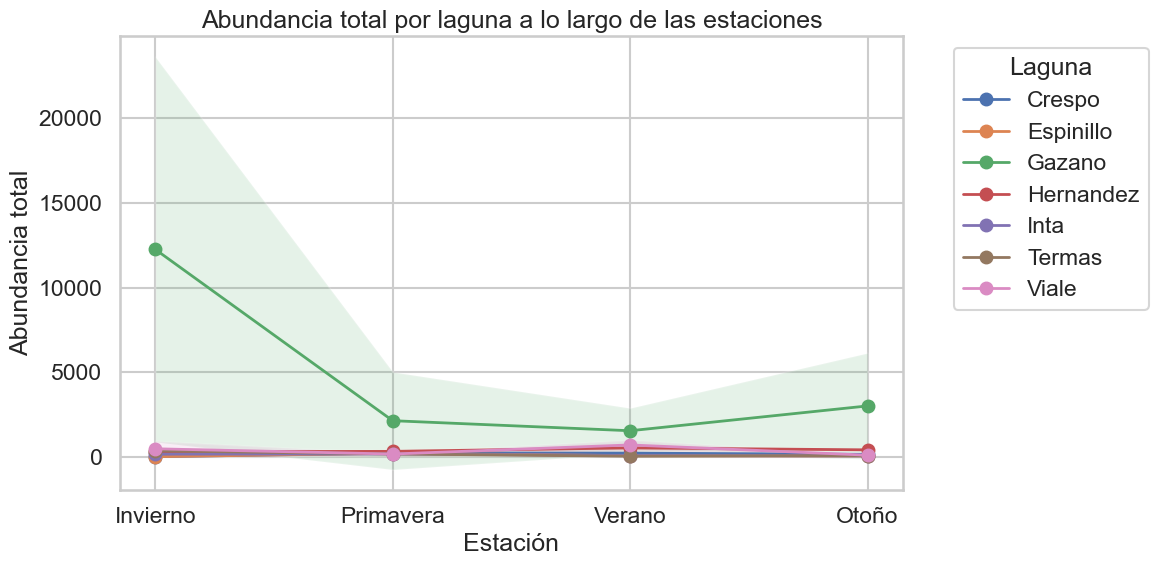

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="whitegrid", context="talk")

df = resumen
# ordenar estaciones
orden_estaciones = ["Invierno", "Primavera", "Verano", "Otoño"]
df["Estacion"] = pd.Categorical(df["Estacion"], categories=orden_estaciones, ordered=True)

# Diccionario para iterar índices
indices = {
    "H_mean": "Diversidad (Shannon)",
    "S_mean": "Riqueza específica",
    "E_mean": "Equitatividad (Pielou)",
    "N_mean": "Abundancia total"
}

# columnas de desviación estándar correspondientes
sd_cols = {
    "H_mean": "H_sd",
    "S_mean": "S_sd",
    "E_mean": "E_sd",
    "N_mean": "N_sd"
}

# ----- Loop de gráficos -----
for col, title in indices.items():

    sd_col = sd_cols[col]

    plt.figure(figsize=(12,6))

    # plot por laguna
    for laguna in df["Laguna"].unique():

        sub = df[df["Laguna"] == laguna].sort_values("Estacion")

        x = np.arange(len(sub))

        plt.plot(
            sub["Estacion"],
            sub[col],
            marker="o",
            linewidth=2,
            label=laguna
        )

        # banda de error (±1 sd)
        plt.fill_between(
            sub["Estacion"],
            sub[col] - sub[sd_col],
            sub[col] + sub[sd_col],
            alpha=0.15
        )

    plt.title(f"{title} por laguna a lo largo de las estaciones")
    plt.xlabel("Estación")
    plt.ylabel(title)
    plt.legend(
        title="Laguna",
        bbox_to_anchor=(1.05, 1),
        loc='upper left'
    )
    plt.tight_layout()
    plt.show()
